In [2]:
import sys
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from datasets import load_dataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("✅ Import thành công!")

✅ Import thành công!


In [ ]:
!pip install -U huggingface-hub

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# ========== HUẤN LUYỆN SFT (Supervised Fine-Tuning) ==========
from trl import SFTConfig

model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
dataset_file = "dataset.jsonl"
output_dir = "./results_reframebot_llama3"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

lora_config = LoraConfig(
    r=6,
    lora_alpha=12,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

sft_config = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="paged_adamw_8bit",
    learning_rate=2e-4,
    num_train_epochs=3,
    logging_steps=50,
    save_steps=100,
    fp16=False,
    bf16=True,
    gradient_checkpointing=True,
    report_to="tensorboard",
    logging_first_step=True,
    max_length=384,
    packing=False
)

print(f"Đang tải model: {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0},
)

dataset = load_dataset("json", data_files=dataset_file, split="train")
print(f"Dataset: {len(dataset)} mẫu")

def formatting_func(example):
    return tokenizer.apply_chat_template(
        example['messages'],
        tokenize=False,
        add_generation_prompt=False
    )

trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    formatting_func=formatting_func,
    train_dataset=dataset,
    peft_config=lora_config,
    args=sft_config
)

print("--- BẮT ĐẦU HUẤN LUYỆN SFT ---")
trainer.train()
print("--- HOÀN TẤT ---")

final_adapter_path = os.path.join(output_dir, "final_checkpoint")
trainer.save_model(final_adapter_path)
print(f"Đã lưu: {final_adapter_path}")

In [ ]:
# ========== HUẤN LUYỆN DPO (Direct Preference Optimization) ==========
from trl import DPOTrainer, DPOConfig

base_model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
adapter_to_tune_path = "D:\\Work\\AI\\Prototype_5\\checkpoint-423"
dpo_dataset_file = "data/dataset_dpo.jsonl"
dpo_output_dir = "./results_reframebot_DPO"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

print("Đang tải base model + adapter SFT...")
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map={"": 0},
)

model = PeftModel.from_pretrained(base_model, adapter_to_tune_path)
print("Model đã sẵn sàng")

dpo_config = DPOConfig(
    output_dir=dpo_output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=24,
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
    learning_rate=5e-6,
    num_train_epochs=3,
    bf16=True,
    logging_steps=2,
    save_steps=2,
    report_to="tensorboard",
    beta=0.1,
    max_length=512,
    max_prompt_length=512,
)

dpo_dataset = load_dataset("json", data_files=dpo_dataset_file, split="train")
dpo_dataset = dpo_dataset.shuffle(seed=42)
print(f"Dataset DPO: {len(dpo_dataset)} mẫu")

dpo_trainer = DPOTrainer(
    model,
    ref_model=None,
    args=dpo_config,
    train_dataset=dpo_dataset,
    processing_class=tokenizer,
    peft_config=lora_config
)

print("--- BẮT ĐẦU HUẤN LUYỆN DPO ---")
dpo_trainer.train(resume_from_checkpoint=True)
print("--- HOÀN TẤT ---")

final_dpo_path = os.path.join(dpo_output_dir, "final_dpo_checkpoint")
dpo_trainer.save_model(final_dpo_path)
print(f"Đã lưu: {final_dpo_path}")

Train: 1340 mẫu | Test: 335 mẫu


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- BẮT ĐẦU HUẤN LUYỆN GUARDRAIL ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.008600,0.979359,0.838806,0.829694,0.860570,0.835859
2,0.791900,0.727722,0.922388,0.922814,0.926490,0.921174
3,0.503200,0.463043,0.952239,0.952604,0.951718,0.953557
4,0.317400,0.282441,0.973134,0.973370,0.971522,0.975642
5,0.188800,0.182296,0.988060,0.988083,0.987198,0.989038
6,0.135300,0.126364,0.985075,0.985053,0.983673,0.986605
7,0.083500,0.094553,0.991045,0.991136,0.989745,0.992701
8,0.073100,0.075240,0.991045,0.991136,0.989745,0.992701
9,0.056600,0.059876,0.991045,0.991136,0.989745,0.992701
10,0.042100,0.057108,0.988060,0.988106,0.986275,0.990268


📊 Epoch 0.12 | Loss: 1.1139 | LR: 1.99e-06
📊 Epoch 0.24 | Loss: 1.1130 | LR: 1.98e-06
📊 Epoch 0.24 | Loss: 1.1130 | LR: 1.98e-06
📊 Epoch 0.36 | Loss: 1.0909 | LR: 1.97e-06
📊 Epoch 0.36 | Loss: 1.0909 | LR: 1.97e-06
📊 Epoch 0.48 | Loss: 1.0700 | LR: 1.95e-06
📊 Epoch 0.48 | Loss: 1.0700 | LR: 1.95e-06
📊 Epoch 0.60 | Loss: 1.0585 | LR: 1.94e-06
📊 Epoch 0.60 | Loss: 1.0585 | LR: 1.94e-06
📊 Epoch 0.71 | Loss: 1.0455 | LR: 1.93e-06
📊 Epoch 0.71 | Loss: 1.0455 | LR: 1.93e-06
📊 Epoch 0.83 | Loss: 1.0225 | LR: 1.92e-06
📊 Epoch 0.83 | Loss: 1.0225 | LR: 1.92e-06
📊 Epoch 0.95 | Loss: 1.0086 | LR: 1.91e-06
📊 Epoch 0.95 | Loss: 1.0086 | LR: 1.91e-06
✅ Eval Loss: 0.9794 | Accuracy: 0.8388 | F1: 0.8297
✅ Eval Loss: 0.9794 | Accuracy: 0.8388 | F1: 0.8297
📊 Epoch 1.07 | Loss: 0.9773 | LR: 1.89e-06
📊 Epoch 1.07 | Loss: 0.9773 | LR: 1.89e-06
📊 Epoch 1.19 | Loss: 0.9588 | LR: 1.88e-06
📊 Epoch 1.19 | Loss: 0.9588 | LR: 1.88e-06
📊 Epoch 1.31 | Loss: 0.9276 | LR: 1.87e-06
📊 Epoch 1.31 | Loss: 0.9276 | LR: 1.

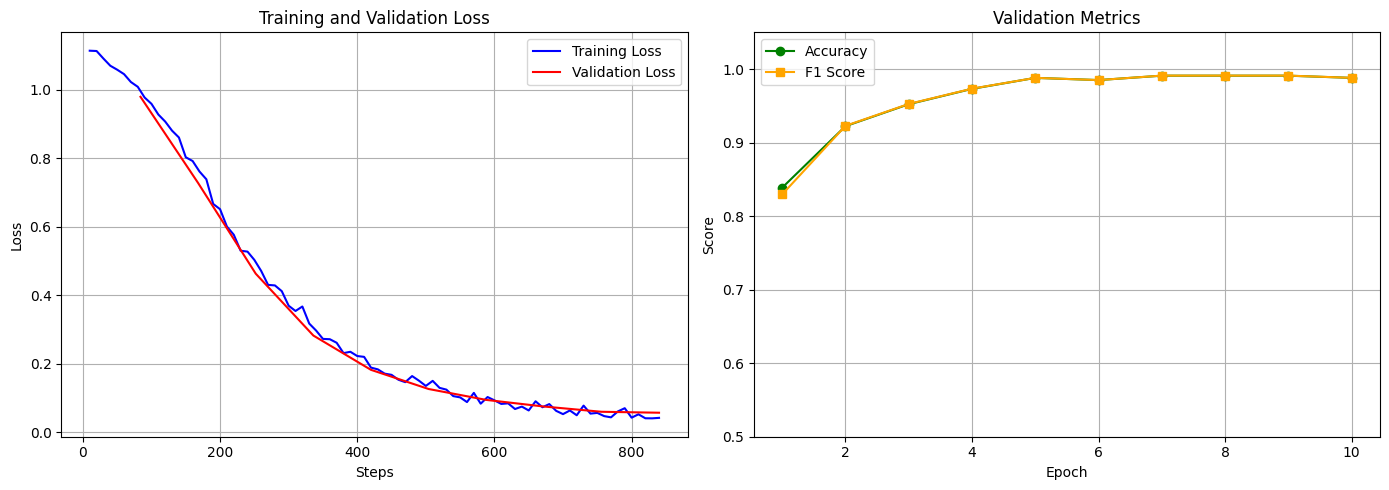

📈 Đã lưu biểu đồ: ./guardrail_model_1/training_metrics.png

✅ Kết quả hợp lý: Accuracy=0.988, F1=0.988


In [9]:
# ========== HUẤN LUYỆN GUARDRAIL (Classifier) ==========
from transformers import AutoModelForSequenceClassification, Trainer, TrainerCallback, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

MODEL_NAME = "distilbert-base-uncased"
DATA_FILE = "data/guardrail_dataset.jsonl"
OUTPUT_DIR = "./guardrail_model_1"

id2label = {0: "TASK_1", 1: "TASK_2", 2: "TASK_3"}
label2id = {"TASK_1": 0, "TASK_2": 1, "TASK_3": 2}

dataset = load_dataset("json", data_files=DATA_FILE, split="train")
dataset = dataset.shuffle(seed=42)
# Tăng test_size để có nhiều data validation hơn
dataset_dict = dataset.train_test_split(test_size=0.2, seed=42)

print(f"Train: {len(dataset_dict['train'])} mẫu | Test: {len(dataset_dict['test'])} mẫu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)

tokenized_datasets = dataset_dict.map(preprocess_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-6,
    per_device_train_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Chọn model tốt nhất theo F1
    greater_is_better=True,
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=10,
    report_to="tensorboard",
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

# Callback để in metrics trong quá trình training
class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Lấy giá trị và kiểm tra kiểu
            epoch = logs.get("epoch")
            loss = logs.get("loss")
            lr = logs.get("learning_rate")
            
            # Chỉ in nếu có giá trị số
            if loss is not None and isinstance(loss, (int, float)):
                epoch_str = f"{epoch:.2f}" if epoch is not None else "N/A"
                lr_str = f"{lr:.2e}" if lr is not None else "N/A"
                print(f"📊 Epoch {epoch_str} | Loss: {loss:.4f} | LR: {lr_str}")
            
            # Nếu có eval metrics
            if "eval_loss" in logs:
                eval_loss = logs.get('eval_loss', 0)
                eval_acc = logs.get('eval_accuracy', 0)
                eval_f1 = logs.get('eval_f1', 0)
                print(f"✅ Eval Loss: {eval_loss:.4f} | "
                      f"Accuracy: {eval_acc:.4f} | "
                      f"F1: {eval_f1:.4f}")
                
                # Cảnh báo nếu overfitting
                if eval_acc >= 0.99 or eval_f1 >= 0.99:
                    print("⚠️  CẢNH BÁO: Có dấu hiệu overfitting!")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
        MetricsCallback(),
        EarlyStoppingCallback(early_stopping_patience=3)  # Dừng nếu không cải thiện sau 3 epochs
    ],
)

print("--- BẮT ĐẦU HUẤN LUYỆN GUARDRAIL ---")
trainer.train()
print("--- HOÀN TẤT ---")

trainer.save_model(OUTPUT_DIR)
print(f"Đã lưu: {OUTPUT_DIR}")

# Vẽ đồ thị Loss và Accuracy
history = trainer.state.log_history

# Tách train và eval logs
train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

# Vẽ đồ thị
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
if train_logs and eval_logs:
    train_steps = [log['step'] for log in train_logs if 'step' in log]
    train_loss = [log['loss'] for log in train_logs if 'loss' in log]
    eval_steps = [log['step'] for log in eval_logs if 'step' in log]
    eval_loss = [log['eval_loss'] for log in eval_logs]
    
    axes[0].plot(train_steps, train_loss, label='Training Loss', color='blue')
    axes[0].plot(eval_steps, eval_loss, label='Validation Loss', color='red')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Kiểm tra overfitting trên đồ thị
    if len(eval_loss) > 2:
        if eval_loss[-1] > eval_loss[-2]:
            axes[0].text(0.5, 0.95, '⚠️ Validation loss tăng - Overfitting!', 
                        transform=axes[0].transAxes, ha='center', color='red', fontsize=10)

# Metrics (Accuracy, F1)
if eval_logs:
    eval_epochs = [log.get('epoch', i) for i, log in enumerate(eval_logs)]
    eval_accuracy = [log.get('eval_accuracy', 0) for log in eval_logs]
    eval_f1 = [log.get('eval_f1', 0) for log in eval_logs]
    
    axes[1].plot(eval_epochs, eval_accuracy, label='Accuracy', color='green', marker='o')
    axes[1].plot(eval_epochs, eval_f1, label='F1 Score', color='orange', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Validation Metrics')
    axes[1].set_ylim([0.5, 1.05])  # Giới hạn trục Y để dễ quan sát
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training_metrics.png")
plt.show()
print(f"📈 Đã lưu biểu đồ: {OUTPUT_DIR}/training_metrics.png")

# In warning cuối cùng
final_acc = eval_logs[-1].get('eval_accuracy', 0) if eval_logs else 0
final_f1 = eval_logs[-1].get('eval_f1', 0) if eval_logs else 0
if final_acc >= 0.99 or final_f1 >= 0.99:
    print("\n⚠️⚠️⚠️ CẢNH BÁO NGHIÊM TRỌNG ⚠️⚠️⚠️")
    print("Model đạt accuracy/F1 quá cao (≥0.99) - Rất có thể OVERFITTING!")
    print("Khuyến nghị:")
    print("  1. Thu thập thêm dữ liệu đa dạng")
    print("  2. Tăng test_size lên 0.3")
    print("  3. Giảm num_train_epochs xuống 5-7")
    print("  4. Test trên data thực tế để kiểm tra hiệu suất")
else:
    print(f"\n✅ Kết quả hợp lý: Accuracy={final_acc:.3f}, F1={final_f1:.3f}")

In [11]:
# Thêm vào cuối cell guardrail training
from sklearn.metrics import classification_report

# Test trên validation set
predictions = trainer.predict(tokenized_datasets["test"])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_datasets["test"]["label"]

print("\n📋 Classification Report:")
print(classification_report(true_labels, pred_labels, 
                          target_names=["TASK_1", "TASK_2", "TASK_3"]))


📋 Classification Report:
              precision    recall  f1-score   support

      TASK_1       0.99      1.00      1.00       107
      TASK_2       0.98      1.00      0.99        91
      TASK_3       1.00      0.98      0.99       137

    accuracy                           0.99       335
   macro avg       0.99      0.99      0.99       335
weighted avg       0.99      0.99      0.99       335

